# Advanced Physical Modelling

In the previous tutorial, we simply modelled the chemistry of a static cloud for 1 Myr. This is unlikely to meet everybody's modelling needs and UCLCHEM is capable of modelling much more complex environments such as hot cores and shocks. In this tutorial, we model both a hot core and a shock to explore how these models work and to demonstrate the workflow that the UCLCHEM team normally follow.

In [1]:
import uclchem
import matplotlib.pyplot as plt
import pandas as pd

# PLease run the notebook on the develop branch only :D jshock still has a bug with timepoints being 1 point too small as of 10-10-2024 (I might have fixed it, Gijs).

## The Hot Core

### Initial Conditions (Phase 1)
UCLCHEM typically starts with the gas in atomic/ionic form with no molecules. However, this clearly is not appropriate when modelling an object such as a hot core. In these objects, the gas is already evolved and there should be molecules in the gas phase as well as ice mantles on the dust. To allow for this, one must provide some initial abundances to the model. There are many ways to do this but we typically chose to run a preliminary model to produce our abundances. In many UCLCHEM papers, we refer to the preliminary model as *phase 1* and the science model as *phase 2*. Phase 1 simply models a collapsing cloud and phase 2 models the object in question.

To do this, we will use `uclchem.model.cloud()` to run a model where a cloud of gas collapses from a density of $10^2 cm^{-3}$ to our hot core density of $10^6 cm^{-3}$, keeping all other parameters constant. During this collapse, chemistry will occur and we can assume the final abundances of this model will be reasonable starting abundances for the hot core. 

In [2]:
# set a parameter dictionary for cloud collapse model
param_dict = {
    "endAtFinalDensity": False,#stop at finalTime
    "freefall": True,#increase density in freefall
    "initialDens": 1e2, #starting density
    "finalDens":1e6, #final density
    "initialTemp": 10.0,#temperature of gas
    "finalTime": 6.0e6, #final time
    "rout":0.1, #radius of cloud in pc
    "baseAv":1.0, #visual extinction at cloud edge.
}
df_stage1_physics, df_stage1_chemistry, final_abundances, result = uclchem.model.cloud(param_dict=param_dict, return_dataframe=True, )

In [3]:
df_stage1_chemistry

,H,#H,H+,@H,H2,#H2,H2+,@H2,H3+,HE,...,HOSO+,#HS2,@HS2,H2S2+,H2S2,#H2S2,@H2S2,E-,BULK,SURFACE
0,5.000000e-01,1.000000e-30,1.000000e-30,1.000000e-30,0.250000,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,0.1,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.823239e-04,1.000000e-30,1.000000e-30
1,5.000000e-01,5.685982e-15,9.674341e-18,4.369999e-24,0.250000,1.798170e-15,9.479999e-18,1.381996e-24,7.975011e-25,0.1,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.823239e-04,5.753474e-24,7.485971e-15
2,5.000000e-01,5.609168e-14,9.674345e-17,4.159792e-22,0.250000,1.773873e-14,9.479987e-17,1.315516e-22,7.800677e-23,0.1,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.018663e-30,1.000000e-30,1.000000e-30,1.823239e-04,5.476646e-22,7.384844e-14
3,5.000000e-01,5.601469e-13,9.674388e-16,4.146187e-20,0.250000,1.771405e-13,9.479870e-16,1.311196e-20,7.796567e-21,0.1,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.037104e-30,1.000000e-30,1.000000e-30,1.823239e-04,5.458717e-20,7.374677e-13
4,5.000000e-01,5.599065e-12,9.674822e-15,4.143311e-18,0.250000,1.771456e-12,9.478701e-15,1.310530e-18,7.795795e-19,0.1,...,1.000000e-30,1.000000e-30,1.000001e-30,1.000000e-30,1.055260e-30,1.000000e-30,1.000001e-30,1.823239e-04,5.455175e-18,7.372323e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2.782454e-08,5.447687e-12,1.267702e-08,4.439699e-08,0.040085,4.967814e-06,6.656903e-15,4.597508e-01,1.262364e-10,0.1,...,3.031539e-26,1.470339e-21,3.223446e-08,1.191161e-19,1.213303e-17,1.118699e-13,4.626349e-08,1.295096e-08,4.601412e-01,4.981617e-06
240,2.783604e-08,5.447844e-12,1.266826e-08,4.439713e-08,0.040085,4.967798e-06,6.656878e-15,4.597510e-01,1.263195e-10,0.1,...,2.743701e-26,1.339404e-21,3.223446e-08,1.081060e-19,1.101172e-17,1.014655e-13,4.626349e-08,1.294225e-08,4.601414e-01,4.981617e-06
241,2.784612e-08,5.447982e-12,1.266057e-08,4.439726e-08,0.040084,4.967784e-06,6.656857e-15,4.597511e-01,1.263924e-10,0.1,...,2.489475e-26,1.223754e-21,3.223446e-08,9.836525e-20,1.001964e-17,9.227183e-14,4.626350e-08,1.293460e-08,4.601415e-01,4.981617e-06
242,2.785501e-08,5.448103e-12,1.265379e-08,4.439738e-08,0.040084,4.967771e-06,6.656838e-15,4.597512e-01,1.264568e-10,0.1,...,2.263830e-26,1.121072e-21,3.223446e-08,8.970411e-20,9.137506e-18,8.410604e-14,4.626350e-08,1.292786e-08,4.601416e-01,4.981617e-06


With that done, we now have a file containing the final abundances of a cloud of gas after this collapse: `param_dict["abundSaveFile"]` we can pass this to our hot core model to use those abundances as our initial abundances.

### Running the Science Model (Phase 2)

We need to change just a few things in `param_dict` to set up the hot core model. The key one is that UCLCHEM saves final abundances to `abundSaveFile` but loads them from `abundLoadFile` so we need to swap that key over to make the abundances we just produced our initial abundances. 

We also want to turn off freefall and change how long the model runs for.


In [4]:
#change other bits of input to set up phase 2
param_dict["initialDens"]=1e6
param_dict["finalTime"]=1e6
param_dict["freefall"]=False

#freeze out is completely overwhelmed by thermal desorption
#so turning it off has no effect on abundances but speeds up integrator.
param_dict["freezeFactor"]=0.0

# param_dict["abstol_factor"]=1e-18
# param_dict["reltol"]=1e-12

df_stage2_physics, df_stage2_chemistry, final_abundances, result =uclchem.model.hot_core(temp_indx=3,max_temperature=300.0, param_dict=param_dict, return_dataframe=True, starting_chemistry=final_abundances)

 At T(=R1) and step size H(=R2), the                                             
 corrector convergence failed repeatedly                                         
 or with ABS(H) = HMIN.                                                          
In the above message, R1 =   0.7284459966846D+13   R2 =   0.5318067845400D+02
 ISTATE -5 - shortening step at time   230520.88502676319      years


In [5]:
df_stage2 = pd.concat((df_stage2_physics, df_stage2_chemistry), axis=1)

In [6]:
df_stage2

,Time,Density,gasTemp,dustTemp,Av,radfield,zeta,dstep,H,#H,...,HOSO+,#HS2,@HS2,H2S2+,H2S2,#H2S2,@H2S2,E-,BULK,SURFACE
0,0.000000e+00,1000000.0,10.000000,10.000000,193.875,1.0,1.0,1.0,2.786288e-08,5.448211e-12,...,2.062682e-26,1.029487e-21,3.223446e-08,8.196884e-20,8.349652e-18,7.682017e-14,4.626350e-08,1.292189e-08,4.601417e-01,4.981617e-06
1,1.000000e-07,1000000.0,10.000000,10.000000,193.875,1.0,1.0,1.0,2.786288e-08,5.448206e-12,...,2.062682e-26,2.028008e-19,3.223446e-08,8.196884e-20,8.349652e-18,7.682046e-14,4.626350e-08,1.292189e-08,4.601417e-01,4.981617e-06
2,1.000000e-06,1000000.0,10.000000,10.000000,193.875,1.0,1.0,1.0,2.786288e-08,5.448166e-12,...,2.062682e-26,2.018742e-18,3.223446e-08,8.196884e-20,8.349652e-18,7.682307e-14,4.626350e-08,1.292189e-08,4.601417e-01,4.981617e-06
3,1.000000e-05,1000000.0,10.000000,10.000000,193.875,1.0,1.0,1.0,2.786288e-08,5.447767e-12,...,2.062682e-26,2.017808e-17,3.223446e-08,8.196884e-20,8.349652e-18,7.684913e-14,4.626350e-08,1.292189e-08,4.601417e-01,4.981617e-06
4,1.000000e-04,1000000.0,10.000003,10.000003,193.875,1.0,1.0,1.0,2.786288e-08,5.443612e-12,...,2.062682e-26,2.017639e-16,3.223446e-08,8.196885e-20,8.349652e-18,7.710978e-14,4.626350e-08,1.292189e-08,4.601417e-01,4.981617e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,9.601000e+05,1000000.0,300.000000,300.000000,193.875,1.0,1.0,1.0,2.624023e-06,2.543694e-30,...,6.347300e-16,1.000000e-30,1.000000e-30,5.819436e-14,2.228318e-08,1.000000e-30,1.000000e-30,2.302194e-08,8.300000e-29,6.775334e-23
190,9.701000e+05,1000000.0,300.000000,300.000000,193.875,1.0,1.0,1.0,2.628702e-06,2.565091e-30,...,6.164580e-16,1.000000e-30,1.000000e-30,5.607756e-14,2.209859e-08,1.000000e-30,1.000000e-30,2.292692e-08,8.300000e-29,6.775334e-23
191,9.801000e+05,1000000.0,300.000000,300.000000,193.875,1.0,1.0,1.0,2.633295e-06,2.586495e-30,...,5.982646e-16,1.000000e-30,1.000000e-30,5.402869e-14,2.191553e-08,1.000000e-30,1.000000e-30,2.283211e-08,8.300000e-29,6.775334e-23
192,9.901000e+05,1000000.0,300.000000,300.000000,193.875,1.0,1.0,1.0,2.637800e-06,2.607905e-30,...,5.801697e-16,1.000000e-30,1.000000e-30,5.204638e-14,2.173399e-08,1.000000e-30,1.000000e-30,2.273747e-08,8.300000e-29,6.775334e-23


Note that we've changed made two changes to the parameters here which aren't strictly necessary but can be helpful in certain situations.

Since the gas temperature increases throughout a hot core model, freeze out is much slower than thermal desorption for all but the first few time steps. Turning it off doesn't affect the abundances but will speed up the solution.

We also change abstol and reltol here, largely to demonstrate their use. They control the integrator accuracy and whilst making them smaller does slow down successful runs, it can make runs complete that stall completely otherwise or give correct solutions where lower tolerances allow issues like element conservation failure to sneak in. If your code does not complete or element conservation fails, you can change them.

### Checking the Result
With a successful run, we can check the output. We first load the file and check the abundance conservation, then we can plot it up.

In [7]:
# phase2_df=uclchem.analysis.read_output_file("../examples/test-output/phase2-full.dat")
uclchem.analysis.check_element_conservation(df_stage2)

{'H': '0.002%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}

In [8]:
# df_stage2.rename(columns={"age":"Time", "density":"Density"}, inplace=True)

In [9]:
df_stage2.iloc[0]

Time        0.000000e+00
Density     1.000000e+06
gasTemp     1.000000e+01
dustTemp    1.000000e+01
Av          1.938750e+02
                ...     
#H2S2       7.682017e-14
@H2S2       4.626350e-08
E-          1.292189e-08
BULK        4.601417e-01
SURFACE     4.981617e-06
Name: 0, Length: 343, dtype: float64

CO
H2O
CH3OH
#CO
#H2O
#CH3OH
@H2O
@CO
@CH3OH


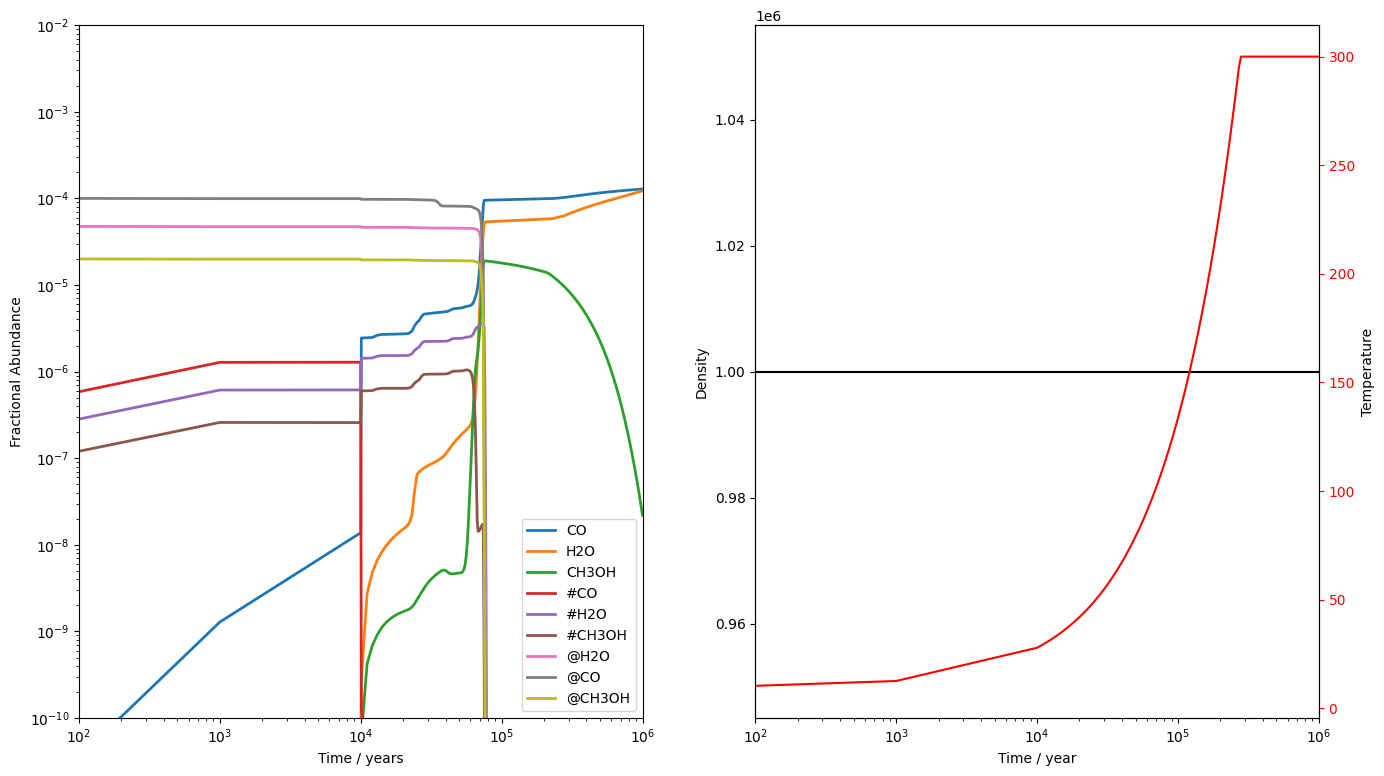

In [10]:
species=["CO","H2O","CH3OH","#CO","#H2O","#CH3OH","@H2O","@CO","@CH3OH"]
fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
ax=uclchem.analysis.plot_species(ax, df_stage2, species)
settings=ax.set(yscale="log",xlim=(1e2,1e6),ylim=(1e-10,1e-2),
            xlabel="Time / years", 
            ylabel="Fractional Abundance",xscale="log")

ax2.plot(df_stage2["Time"],df_stage2["Density"],color="black")
ax2.set(xscale="log")
ax3=ax2.twinx()
ax3.plot(df_stage2["Time"],df_stage2["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red",xlim=(1e2,1e6))
ax3.tick_params(axis='y', colors='red')

Here, we see the value of running a collapse phase before the science run. Having run a collapse, we start this model with well developed ices and having material in the surface and bulk allows us to properly model the effect of warm up in a hot core. For example, the @CO abundance is $\sim10^{-4}$ and #CO is $\sim10^{-6}$. As the gas warms to around 30K, the #CO abundance drops drastically as CO's binding energy is such that it is efficiently desorbed from the surface at this temperature. However, the rest of the CO is trapped in the bulk, surrounded by more strongly bound H2O molecules. Thus, the @CO abundance stays high until the gas reaches around 130K, when the H2O molecules are released along with the entire bulk.

## Shocks

Essentially the same process should be followed for shocks. Let's run a C-type and J-type shock through a gas of density $10^4 cm^{-3}$. Again, we first run a simple cloud model to obtain some reasonable starting abundances, then we can run the shocks.

In [11]:
# set a parameter dictionary for phase 1 collapse model

param_dict = {
    "endAtFinalDensity": False,#stop at finalTime
    "freefall": True,#increase density in freefall
    "initialDens": 1e2, #starting density
    "finalDens":1e4, #final density
    "initialTemp": 10.0,#temperature of gas
    "finalTime": 6.0e6, #final time
    "rout":0.1, #radius of cloud in pc
    "baseAv":1.0, #visual extinction at cloud edge.
    # "abundSaveFile": "../examples/test-output/shockstart.dat",
}
df_stage1_physics, df_stage1_chemistry, final_abundances, result = uclchem.model.cloud(param_dict=param_dict, return_dataframe=True, )

### C-shock

We'll first run a c-shock. We'll run a 40 km s $^{-1}$ shock through a gas of density $10^4$ cm $^{-3}$, using the abundances we just produced. Note that c-shock is the only model which returns an additional output in its result list. Not only is the first element the success flag indicating whether UCLCHEM completed, the second element is the dissipation time of the shock. We'll use that time to make our plots look nicer, cutting to a reasonable time. You can also obtain it from `uclchem.utils.cshock_dissipation_time()`.

In [12]:
#change other bits of input to set up phase 2
param_dict["initialDens"]=1e4
param_dict["finalTime"]=1e6
if "abundSaveFile" in param_dict:
    param_dict.pop("abundSaveFile")
# param_dict["abundLoadFile"]="../examples/test-output/shockstart.dat"
# param_dict["outputFile"]="../examples/test-output/cshock.dat"


df_stage2_physics, df_stage2_chemistry, dissipation_time, final_abundances, result = uclchem.model.cshock(shock_vel=40,param_dict=param_dict, return_dataframe=True, starting_chemistry=final_abundances)
# result,dissipation_time=result

 Cannot have freefall on during cshock
 setting freefall=0 and continuing


The code completes fine. We do get a couple of warnings though. First, we're informed that `freefall` must be set to False for the C-shock model. Then we get a few integrator warnings. These are not important and can be ignored as long as the element conservation looks ok. However, it is an indication that the integrator did struggle with these ODEs under these conditions.

In [13]:
df_stage2 = pd.concat((df_stage2_physics, df_stage2_chemistry), axis=1)
uclchem.analysis.check_element_conservation(df_stage2)

{'H': '0.005%', 'N': '1.257%', 'C': '1.458%', 'O': '1.302%'}

In [14]:
# df_stage2.rename(columns={"age":"Time", "density":"Density"}, inplace=True) 

CO
H2O
CH3OH
NH3
$CO
$H2O
$CH3OH
$NH3


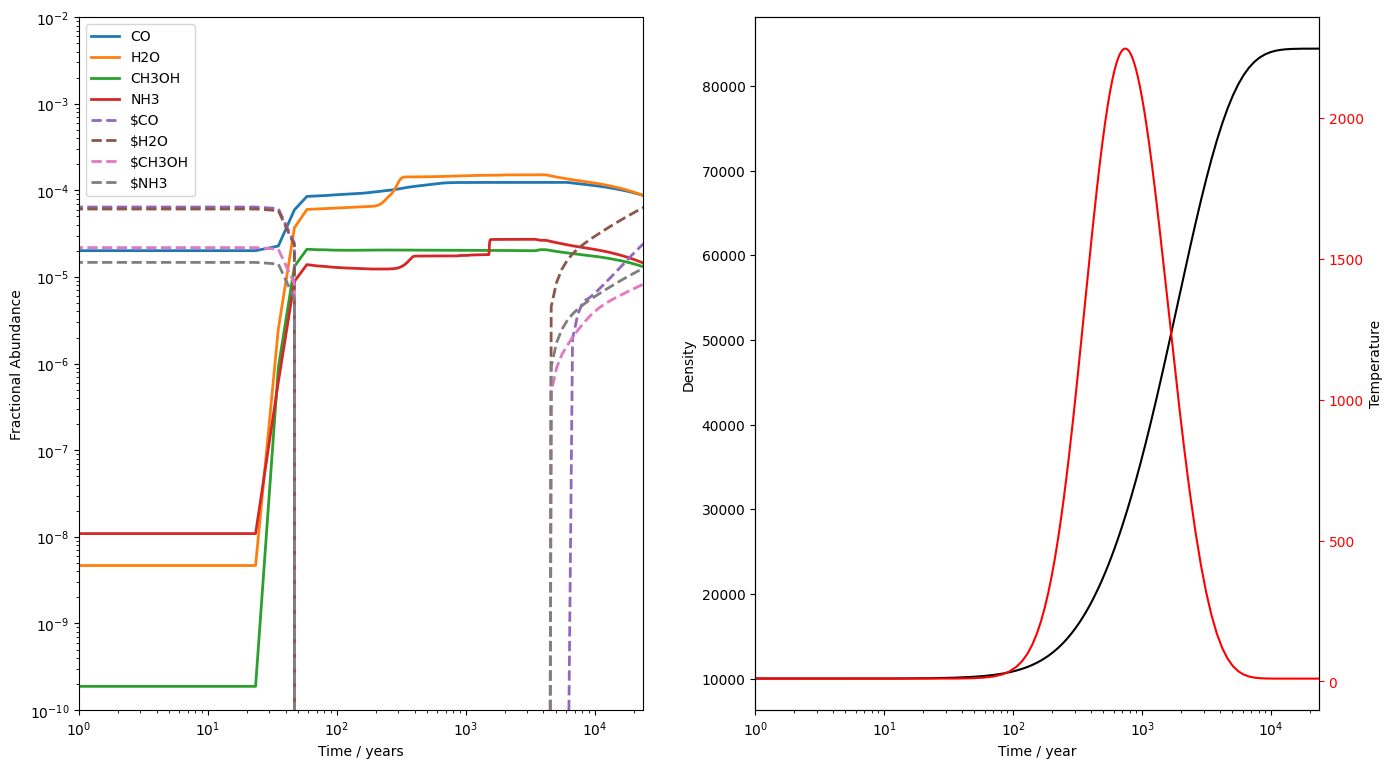

In [15]:
species=["CO","H2O","CH3OH","NH3","$CO","$H2O","$CH3OH","$NH3"]

fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
ax=uclchem.analysis.plot_species(ax,df_stage2,species)
settings=ax.set(yscale="log",xlim=(1,20*dissipation_time),ylim=(1e-10,1e-2),
            xlabel="Time / years", 
            ylabel="Fractional Abundance",xscale="log")

ax2.plot(df_stage2["Time"],df_stage2["Density"],color="black")
ax2.set(xscale="log")
ax3=ax2.twinx()
ax3.plot(df_stage2["Time"],df_stage2["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red",xlim=(1,20*dissipation_time))
ax3.tick_params(axis='y', colors='red')

### J-shock
Running a j-shock is a simple case of changing function. We'll run a 10 km s $^{-1}$ shock through a gas of density $10^3$ cm $^{-3}$ gas this time. Note that nothing stops us using the intial abundances we produced for the c-shock. UCLCHEM will not check that the initial density matches the density of the `abundLoadFile`. It may not always be a good idea to do this but we should remember the intial abundances really are just a rough approximation. 

By default UCLCHEM uses 500 timepoints for a model, but this turns out not be enough, which is why we increase the number of timepoints to 1500.

In [16]:
# TODO: maybe add a function/method to adjust the number of timepoints in UCLCHEM WITHOUT restarting the kernel

param_dict["initialDens"]=1e3
param_dict["freefall"]=False #lets remember to turn it off this time
param_dict["reltol"]=1e-12

shock_vel=10.0

df_jshock_physics, df_jshock_chemistry, final_abundances, result = uclchem.model.jshock(shock_vel=shock_vel,param_dict=param_dict, return_dataframe=True, starting_chemistry=final_abundances, timepoints=1500)

This time, we've turned off the freefall option and made reltol a little more stringent. The j-shock ends up running a bit slower but we get no warnings on this run.

In [17]:
df_jshock = pd.concat((df_jshock_physics, df_jshock_chemistry), axis=1)
# df_jshock.rename(columns={"age":"Time", "density":"Density"}, inplace=True)
uclchem.analysis.check_element_conservation(df_jshock)

{'H': '0.102%', 'N': '1.568%', 'C': '1.138%', 'O': '1.688%'}

In [18]:
df_jshock.shape

(1317, 343)

CO
H2O
CH3OH
NH3
$CO
$H2O
$CH3OH
$NH3


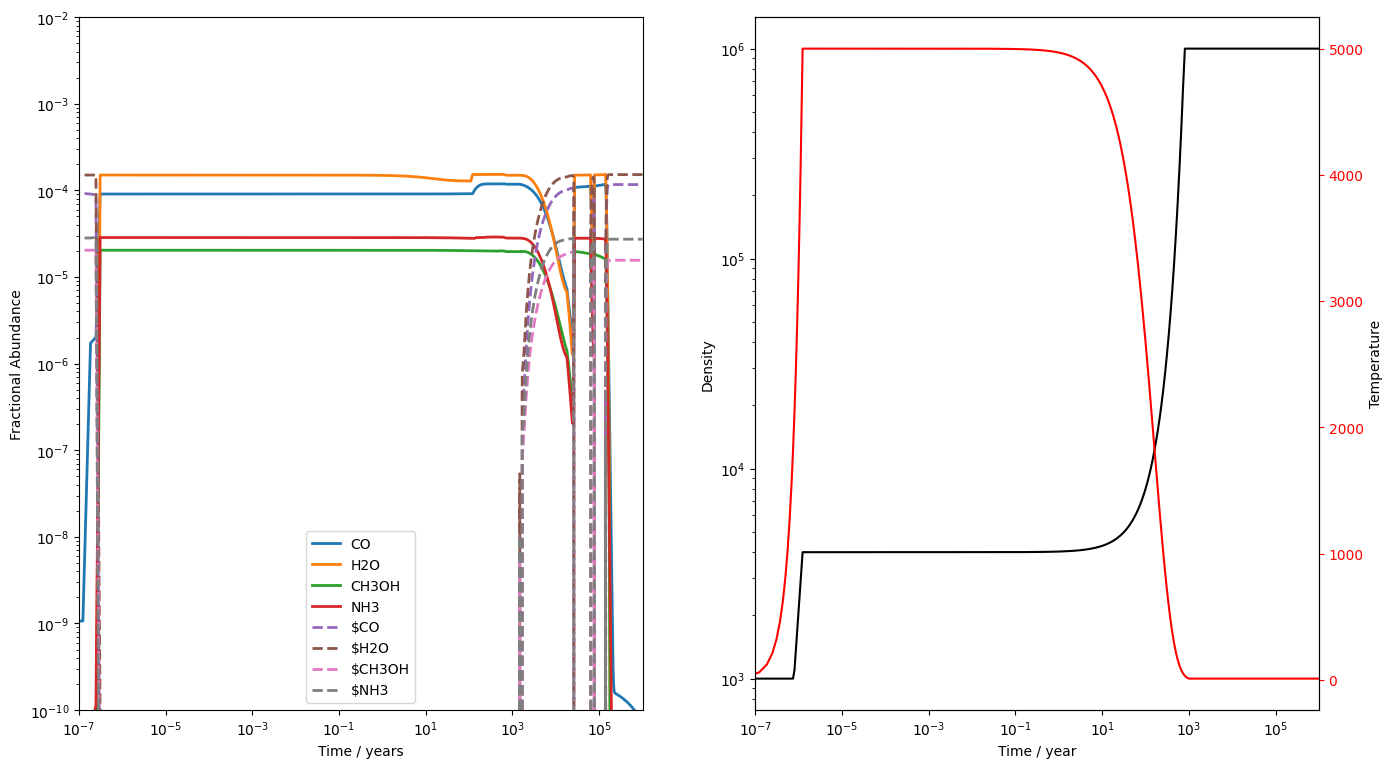

In [19]:
species=["CO","H2O","CH3OH","NH3","$CO","$H2O","$CH3OH","$NH3"]

fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
ax=uclchem.analysis.plot_species(ax,df_jshock,species)
settings=ax.set(yscale="log",xlim=(1e-7,1e6),ylim=(1e-10,1e-2),
            xlabel="Time / years", 
            ylabel="Fractional Abundance",xscale="log")

ax2.plot(df_jshock["Time"],df_jshock["Density"],color="black")
ax2.set(xscale="log",yscale="log")
ax3=ax2.twinx()
ax3.plot(df_jshock["Time"],df_jshock["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red",xlim=(1e-7,1e6))
ax3.tick_params(axis='y', colors='red')

That's everything! We've run various science models using reasonable starting abundances that we produced by running a simple UCLCHEM model beforehand. One benefit of this method is that the abundances are consistent with the network. If we start with arbitrary, perhaps observationally motivated, abundances, it would be possible to initiate the model in a state our network could never produce. 

However, one should be aware of the limitations of this method. A freefall collapse from low density to high is not really how a molecular cloud forms and so the abundances are only approximately similar to values they'd truly have in a real cloud. Testing whether your results are sensitive to things like the time you run the preliminary for or the exact density is a good way to make sure these approximations are not problematic.

Bear in mind that you can use `abundSaveFile` and `abundLoadFile` in the same model run. This lets you chain model runs together. For example, you could run a c-shock from a cloud model as we did here and then a j-shock with the c-shock's abundances as the initial abundances.